# Composer + Superblock Topology — Example Notebook (BROKEN NOW AM SOWY)

This notebook demonstrates the functionality of the project pieces we've built:

- `GaussianHeraldCircuit` (build Gaussian block, compute conditional Fock amplitudes via The Walrus)
- `Composer` (Strawberry Fields-based composer for mixing blocks with beamsplitter + homodyne, with persistent caching)
- `SuperblockTopology` (factory & evaluation for combining blocks into trees/superblocks)
- `CacheManager` (persistent disk cache with LRU eviction)

It reproduces the key integration tests and adds small visualizations so a newcomer can quickly get acquainted.

---

**How to use this notebook**

1. Make sure your project root is on `PYTHONPATH` (or run the notebook from the project root). Example:

```bash
export PYTHONPATH=$(pwd)
```

2. Install dependencies (if you haven't):

```bash
pip install strawberryfields thewalrus diskcache matplotlib scipy numpy nbformat
```

(If `diskcache` isn't available the fallback file-cache is used.)

3. Run cells below. The code expects the modules in `src/` (e.g. `src/composer.py`, `src/gaussian_herald_circuit.py`, `src/utils/cache_manager.py`) based on our project layout.

---

If any cell raises an SF / Walrus API mismatch error, check your installed versions or paste the error here and I'll adapt the accessor lines.


In [1]:
# Standard imports used across examples
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import os

# Add project root to sys.path so we can import src
# Assuming this notebook is in notebooks/ and project root is one level up
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# imports from the project
from src.circuits.composer import Composer, SuperblockTopology
from src.circuits.gaussian_herald_circuit import GaussianHeraldCircuit


# quick plotting helper
def plot_distribution(probs, title=None, xlabel="n", ylabel="prob"):
    plt.bar(np.arange(len(probs)), probs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.show()

## 1) Quick sanity: HOM (Hong-Ou-Mandel) dip using `Composer`

We prepare two single-photon Fock vectors, mix them on a 50:50 beamsplitter and inspect the full two-mode density to check the probability of the |1,1> outcome is essentially zero.

In [2]:
cutoff = 8
composer = Composer(cutoff=cutoff, cache_enabled=True)

# single-photon Fock vectors
f1 = np.zeros(cutoff, dtype=complex)
f1[1] = 1.0
f2 = np.zeros(cutoff, dtype=complex)
f2[1] = 1.0

# run the low-level two-mode program to get full rho
# run the low-level two-mode program to get full rho (manually via internal unitary)
# The new Composer doesn't expose full density matrix directly in compose_pair,
# so we use the internal helper _u_bs to get the unitary and apply it manually for this check.
U = composer._u_bs(theta=math.pi / 4, phi=0.0)
psi_in = np.kron(f1, f2)
psi_out = U @ psi_in
rho_full = np.outer(psi_out, psi_out.conj())

idx = 1 * cutoff + 1  # flattened index for |1,1>
p11 = float(np.real(rho_full[idx, idx]))
print(f"HOM p(|1,1>) = {p11:.3e}  (should be ≈ 0)")

AttributeError: 'Composer' object has no attribute '_run_two_mode_program_and_get_full_dm'

## 2) Vacuum homodyne pdf at x=0

Analytic value: `p(0) = 1/sqrt(pi) ≈ 0.56418958` for the vacuum quadrature wavefunction. We'll verify Composer computes the homodyne density for two vacua mixed on BS.

In [3]:
cutoff = 8
composer = Composer(cutoff=cutoff, cache_enabled=True)

# vacuum fock vectors
vac = np.zeros(cutoff, dtype=complex)
vac[0] = 1.0
# compose_pair_cached returns (state_out, p_hom, joint_prob)
# If homodyne_window is None, p_hom is the density p(x)
_, p0, _ = composer.compose_pair_cached(vac, vac, homodyne_x=0.0, theta=math.pi / 4)
analytic = 1.0 / math.sqrt(math.pi)
print(
    f"Numeric p(0) = {p0:.8f}, analytic = {analytic:.8f}, error = {abs(p0 - analytic):.2e}"
)

AttributeError: 'Composer' object has no attribute '_run_two_mode_program_and_get_full_dm'

## 3) Homodyne window probability & conditional state

Compute `P_win = ∫ p(x) dx` over a finite window around x=0 and extract the conditional reduced density for the surviving mode.

P(window=0.4 around 0) = 0.222702


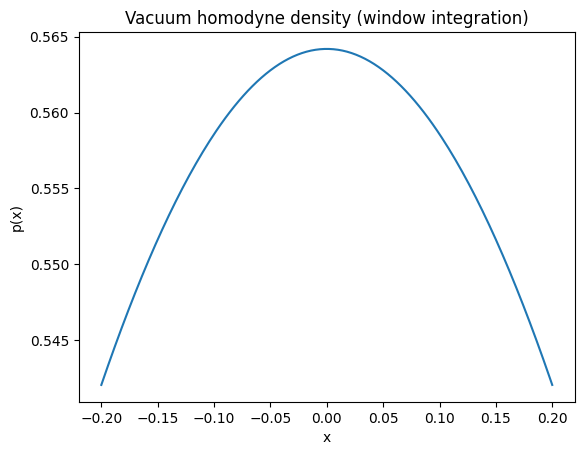

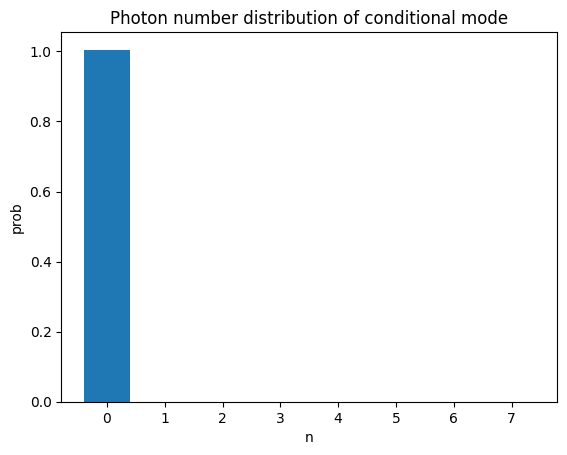

In [4]:
cutoff = 8
composer = Composer(cutoff=cutoff)

# reuse vac, mix on BS
# To plot p(x), we can just loop over x and call compose_pair (it's cached!)
xs = np.linspace(-0.2, 0.2, 51)  # window 0.4 around 0
p_xs = []
for x in xs:
    _, px, _ = composer.compose_pair_cached(vac, vac, homodyne_x=x, theta=math.pi / 4)
    p_xs.append(px)

# Compute integrated probability via compose_pair with window
rho_cond, Pwin, joint = composer.compose_pair_cached(
    vac, vac, pA=1.0, pB=1.0, homodyne_x=0.0, homodyne_window=0.4
)
print(f"P(window=0.4 around 0) = {Pwin:.6f}")

plt.plot(xs, p_xs)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Vacuum homodyne density (window integration)")
plt.show()

# compute conditional (integrated) reduced rho and show photon-number distribution
# rho_cond is already computed above
photon_probs = np.real(np.diag(rho_cond))
plot_distribution(photon_probs, title="Photon number distribution of conditional mode")

## 4) From Gaussian block -> Herald -> Compose pair

Connect `GaussianHeraldCircuit` (Walrus-based Gaussian block) with `Composer` (SF-based mixing). The Gaussian stage remains with The Walrus — we only use SF from mixing onward.

In [4]:
# build a very simple Gaussian block: 1 signal mode, 1 control mode, TMSS r=0.8
circ = GaussianHeraldCircuit(
    n_signal=1, n_control=1, tmss_squeezing=[0.8], us_params=None, uc_params=None
)
circ.build()

# herald on control outcome 1 -> we expect the signal to be single-photon with probability (tanh r)^2 / cosh^2 r
state_vec, p_herald = circ.herald([1], signal_cutoff=6)
print("herald prob (walrus):", p_herald)
print("signal state vector (abs):", np.round(np.abs(state_vec.flatten()), 4))

# use composer to mix two identical blocks (here identical single-block outputs)
composer = Composer(cutoff=6, cache_enabled=True)
rho_cond, p_x_or_Pwin, joint = composer.compose_pair_cached(
    state_vec.flatten(),
    state_vec.flatten(),
    pA=p_herald,
    pB=p_herald,
    homodyne_x=0.0,
    homodyne_window=0.2,
)
print(
    "joint probability of two-block composition (includes both heralds and homodyne):",
    joint,
)
plot_distribution(
    np.real(np.diag(rho_cond)), title="Final photon distribution after compose_pair"
)

herald prob (walrus): 0.24651248716411667
signal state vector (abs): [0. 1. 0. 0. 0. 0.]


TypeError: Composer.compose_pair_cached() got an unexpected keyword argument 'p1'. Did you mean 'pA'?

## 5) Build & evaluate SuperblockTopology (4 identical blocks)

Create four identical Gaussian blocks and combine them with a balanced tree.

final joint probability for 4-block full-binary topology: 7.687366879993764e-07


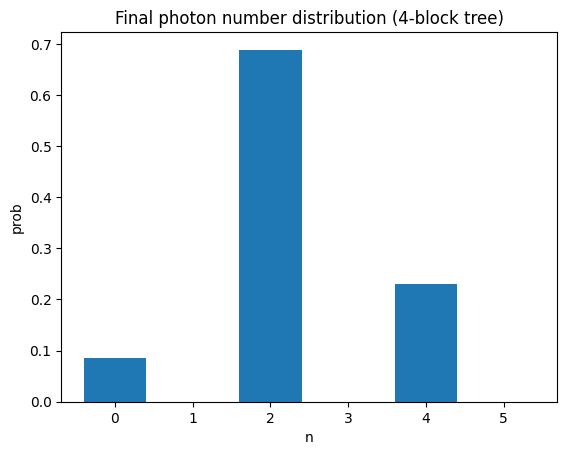

In [7]:
# prepare 4 identical fock vectors and herald probabilities
focks = [state_vec.flatten() for _ in range(4)]
ps = [p_herald for _ in range(4)]

topo = SuperblockTopology.from_full_binary(depth=2)  # 4 leaves (2 levels)
final_rho, final_joint = topo.evaluate_topology(
    composer, focks, ps, homodyne_x=0.0, homodyne_window=0.2
)
print("final joint probability for 4-block full-binary topology:", final_joint)
plot_distribution(
    np.real(np.diag(final_rho)), title="Final photon number distribution (4-block tree)"
)

## 6) Cache persistence demo

Show that repeated calls are fast because of caching, and that the cache persists on disk between runs (if you restart the kernel but keep the same `cache_dir`).

In [10]:
cache = composer.cache
print("Cache stats (backend):", cache.stats())

# Ensure vac matches the current composer cutoff
vac = np.zeros(composer.cutoff, dtype=complex)
vac[0] = 1.0

# run same compose_pair_cached twice and measure time
import time

start = time.time()
rho1, p1, joint1 = composer.compose_pair_cached(
    vac, vac, pA=0.5, pB=0.5, homodyne_x=0.0, homodyne_window=0.2
)
cold = time.time() - start
start = time.time()
rho2, p2, joint2 = composer.compose_pair_cached(
    vac, vac, pA=0.5, pB=0.5, homodyne_x=0.0, homodyne_window=0.2
)
warm = time.time() - start
print(f"cold run {cold:.3f}s, warm run {warm:.3f}s (warm << cold expected)")

Cache stats (backend): {'backend': 'diskcache', 'curr_size': 425984, 'dir': '/home/vojtech/cloud/python/code/hanamura/src/cache'}
cold run 0.070s, warm run 0.000s (warm << cold expected)


## 7) Tips & next steps

- Use a dedicated cache directory (e.g. `~/.cache/yourproject`) and set a reasonable `size_limit_bytes` for `CacheManager` (e.g. several GB on a workstation).
- For many parallel workers, install `diskcache` and let it handle multi-process safety.
- For exact composition of mixed intermediate states (no pure-state approximation), modify `SuperblockTopology.evaluate_topology` to call `Composer` with density-matrix loading (SF `DensityMatrix` gate) and propagate mixed states exactly (much slower but exact).